# 1. Classification Accuracy and MBTI Dimension Prediction Visualization
In this step, MBTI types are predicted using a pre-trained Linear SVC model. The classification accuracy is calculated for each MBTI dimension (I-E, N-S, T-F, J-P) and visualized using a color-coded bar chart to enable a clear comparison of model performance across the different personality dimensions.

Accuracy for I-E: 0.7538
Accuracy for N-S: 0.8572
Accuracy for T-F: 0.5154
Accuracy for J-P: 0.5175


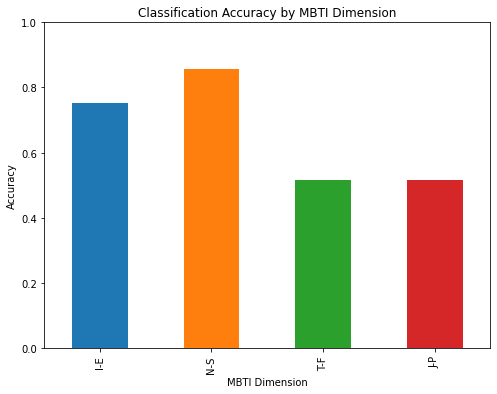

,type,pred_mbti,I-E_true,I-E_pred,N-S_true,N-S_pred,T-F_true,T-F_pred,J-P_true,J-P_pred
0,INFJ,ENTP,I,E,N,N,F,T,J,P
1,ENTP,INTP,E,I,N,N,T,T,P,P
2,INTP,INFP,I,I,N,N,T,F,P,P
3,INTJ,INFP,I,I,N,N,T,F,J,P
4,ENTJ,INTP,E,I,N,N,T,T,J,P


In [51]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

#load the pre-trained model
model_linear_SVC = joblib.load('mbti_linear_svc_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
target_encoder = joblib.load('label_encoder.pkl')
#load the dataset 
data = pd.read_csv('data/mbti_1.csv')

#function to predict MBTI type
def predict_mbti(text):
    #transform text into a vector using the TF-IDF 
    text_vectorized = vectorizer.transform([text])
    #use the pre-trained model to predict the MBTI type
    prediction = model_linear_SVC.predict(text_vectorized)
    #return the predicted MBTI type
    return target_encoder.inverse_transform(prediction)[0]

#predict MBTI types
data['pred_mbti'] = data['posts'].apply(predict_mbti)

#split MBTI types into dimensions
dimensions = ['I-E', 'N-S', 'T-F', 'J-P']
#loop through each MBTI dimension using its index and label
for i, dim in enumerate(dimensions):
    #extract the true value for the current dimension from the 'type' column
    data[f'{dim}_true'] = data['type'].str[i]
    #extract the predicted value for the current dimension from the 'pred_mbti' column
    data[f'{dim}_pred'] = data['pred_mbti'].str[i]

#initialize an empty dictionary to store accuracy for each dimension
accuracy = {}
#loop through each MBTI dimension to calculate accuracy
for dim in dimensions:
    #calculate the accuracy by comparing true and predicted values for the current dimension
    acc = (data[f'{dim}_true'] == data[f'{dim}_pred']).mean()
    #store the calculated accuracy in the dictionary with the dimension as the key
    accuracy[dim] = acc
    print(f'Accuracy for {dim}: {acc:.4f}')

#create a bar chart of the accuracies
accuracy_df = pd.DataFrame({'Dimension': dimensions, 'Accuracy': accuracy.values()})
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
accuracy_df.plot(kind='bar', x='Dimension', y='Accuracy', color=colors, legend=False, figsize=(8,6))
plt.xlabel('MBTI Dimension')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy by MBTI Dimension')
plt.ylim(0, 1)
plt.show()

#define a function to highlight the background color of predicted values based on whether they match the true values
#rer:https://stackoverflow.com/questions/41203959/conditionally-format-python-pandas-cell
def highlight_max(row):
    styles = []
    for col in row.index:
        #check if column is a predicted value
        if '_pred' in col:
            #extract the dimension name
            dim = col.split('_')[0]
            #find the corresponding true value column
            true_col = f'{dim}_true'
            #apply green background if prediction matches true value, otherwise red
            styles.append('background-color: green; color: white' if row[col] == row[true_col] 
                          else 'background-color: red; color: white')
        else:
            #default text color for non-prediction columns
            styles.append('color:white')
    return styles

#display the first 5 rows with highlighting in red and green
#ref:https://blog.finxter.com/5-best-ways-to-name-columns-explicitly-in-a-pandas-dataframe/
display_columns = ['type', 'pred_mbti'] + [f'{dim}_{suffix}' for dim in dimensions for suffix in ('true', 'pred')]
#apply the color highlighting to the prediction columns based on whether the prediction is correct
#ref:https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.apply.html
styled_table = data[display_columns].head().style.apply(highlight_max, axis=1)
#display
styled_table

# 2. Enhancing MBTI Prediction through Semantic Analysis Using BERT
Building on the previous step, where the model faced challenges in predicting the T-F and J-P dimensions with lower accuracy, this step incorporates BERT embeddings to enhance the model's semantic understanding of text. By combining BERT's deep contextual analysis with TF-IDF features, the model aims to improve its performance, particularly for the decision-making traits (T-F and J-P dimensions). The same original dataset is used, and final models are saved for each MBTI dimension, culminating in a refined dataset for more accurate MBTI predictions.

Saved model for EI dimension to saved_models/svc_model_EI.pkl
              precision    recall  f1-score   support

           E       0.69      0.55      0.61       382
           I       0.88      0.93      0.90      1353

    accuracy                           0.85      1735
   macro avg       0.79      0.74      0.76      1735
weighted avg       0.84      0.85      0.84      1735

Accuracy for EI: 0.8472622478386167


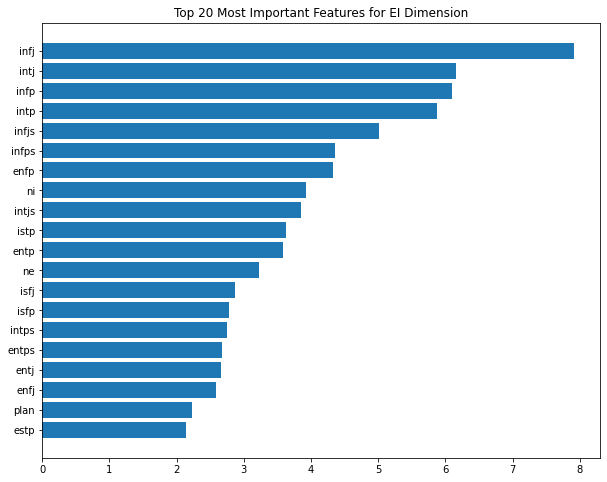

Saved model for NS dimension to saved_models/svc_model_NS.pkl
              precision    recall  f1-score   support

           N       0.91      0.96      0.94      1489
           S       0.66      0.41      0.51       246

    accuracy                           0.89      1735
   macro avg       0.78      0.69      0.72      1735
weighted avg       0.87      0.89      0.87      1735

Accuracy for NS: 0.885878962536023


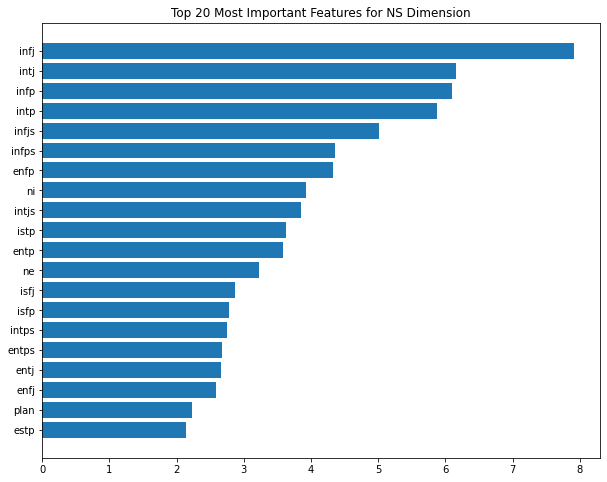

Saved model for FT dimension to saved_models/svc_model_FT.pkl
              precision    recall  f1-score   support

           F       0.83      0.85      0.84       937
           T       0.82      0.80      0.81       798

    accuracy                           0.83      1735
   macro avg       0.82      0.82      0.82      1735
weighted avg       0.83      0.83      0.83      1735

Accuracy for FT: 0.8253602305475505


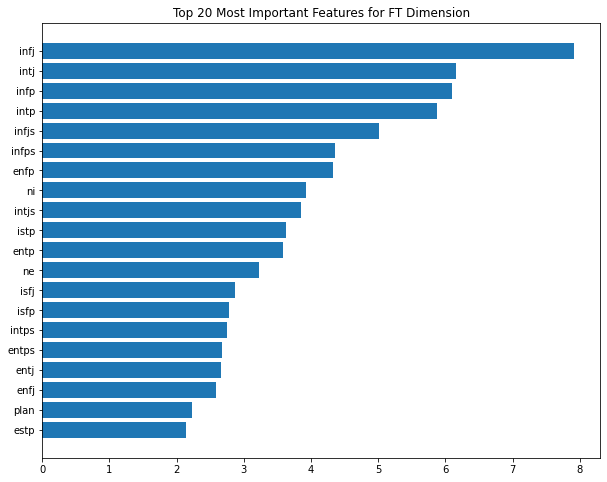

Saved model for PJ dimension to saved_models/svc_model_PJ.pkl
              precision    recall  f1-score   support

           J       0.71      0.65      0.68       669
           P       0.79      0.83      0.81      1066

    accuracy                           0.76      1735
   macro avg       0.75      0.74      0.74      1735
weighted avg       0.76      0.76      0.76      1735

Accuracy for PJ: 0.7613832853025937


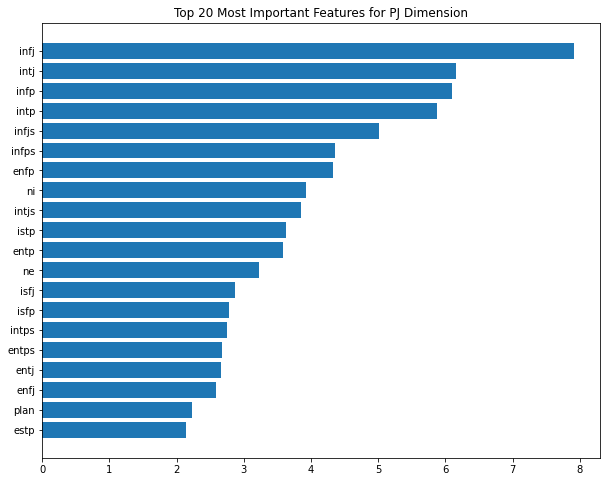

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertModel
import torch
import joblib
import os

#load the dataset
df = pd.read_csv('data/mbti_1.csv')
#fill missing values with empty strings
df['cleaned_text'] = df['posts'].fillna('')

#extract the four MBTI dimensions
df['EI'] = df['type'].apply(lambda x: 'E' if 'E' in x else 'I')
df['NS'] = df['type'].apply(lambda x: 'N' if 'N' in x else 'S')
df['FT'] = df['type'].apply(lambda x: 'F' if 'F' in x else 'T')
df['PJ'] = df['type'].apply(lambda x: 'P' if 'P' in x else 'J')

#load the pre-trained model
vectorizer = joblib.load('tfidf_vectorizer.pkl')
#transform the text using the pre-trained vectorizer
X_tfidf = vectorizer.transform(df['cleaned_text'])

#ref:https://huggingface.co/docs/transformers/model_doc/bert
#load the pre-trained BERT tokenizer for tokenizing text inputs
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#load the pre-trained BERT model (base, uncased) for extracting text embeddings
bert_model = BertModel.from_pretrained('bert-base-uncased')

#define a function to generate BERT embeddings with batch processing,ref:https://microsoft.github.io/batch-inference/examples/bert_embedding.html
def predict_batch(text_list):
    #initialize an empty list to store the embeddings
    embeddings = []
    #set batch size
    batch_size = 32 
    #loop through the text list in batches
    for i in range(0, len(text_list), batch_size):
        #get a batch of text for processing
        batch_text = text_list[i:i+batch_size]
        #tokenize the batch using the BERT tokenizer, converting it into tensors
        #ref:https://huggingface.co/docs/transformers/pad_truncation
        inputs = tokenizer(batch_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        #disable gradient calculation to save memory during inference
        with torch.no_grad():
            #generate the BERT embeddings using the model
            outputs = bert_model(**inputs)
        #extract the embeddings of the CLS token ,ref:https://huggingface.co/docs/transformers/main_classes/output
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        #append the CLS embeddings for the batch
        embeddings.append(cls_embeddings)
    #stack all embeddings from batches into a single array
    return np.vstack(embeddings)

#generate BERT embeddings for the entire dataset
bert_embeddings = predict_batch(df['cleaned_text'].tolist())

#combine TF-IDF features with BERT embeddings,ref:https://www.geeksforgeeks.org/numpy-hstack-in-python/
X_combined = np.hstack((X_tfidf.toarray(), bert_embeddings))

#create a directory to save models
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

#define the MBTI dimensions to analyze
dimensions = ['EI', 'NS', 'FT', 'PJ']
#iterate over each MBTI dimension
for dimension in dimensions:
    #set the target variable for the current dimension
    y = df[dimension]
    #split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42) 
    #train and evaluate an SVC model with a linear kernel
    model = SVC(kernel='linear') 
    model.fit(X_train, y_train)
    #save model
    model_filename = f'saved_models/svc_model_{dimension}.pkl'
    joblib.dump(model, model_filename)
    print(f"Saved model for {dimension} dimension to {model_filename}")

    #make predictions on the test set
    y_pred = model.predict(X_test)
    #print the classification report 
    print(classification_report(y_test, y_pred))
    #calculate the accuracy 
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dimension}: {accuracy}")

    #check if the model has 'coef_' attribute,ref:https://docs.python.org/3/library/functions.html#hasattr
    #ref:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    if hasattr(model, 'coef_'):
        #get the absolute values of the model coefficients to determine feature importance
        feature_importances = np.abs(model.coef_[0])
        #get the feature names from the TF-IDF vectorizer,ref:https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
        tfidf_feature_names = vectorizer.get_feature_names_out()
        #create feature names for BERT embeddings, labeling each dimension as 'BERT_0', 'BERT_1', etc.
        bert_feature_names = [f'BERT_{i}' for i in range(bert_embeddings.shape[1])]
        #concatenate the TF-IDF and BERT feature names into a single list,ref:https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
        all_feature_names = np.concatenate([tfidf_feature_names, bert_feature_names])
        #sort the indices of feature importances in descending order 
        indices = np.argsort(feature_importances)[::-1]

        #display the top 20 most important features
        top_n = 20
        #get the names of the top N important features
        top_features = [all_feature_names[i] for i in indices[:top_n]]
        plt.figure(figsize=(10, 8))
        plt.title(f"Top 20 Most Important Features for {dimension} Dimension")
        plt.barh(range(top_n), feature_importances[indices[:top_n]], align="center")
        plt.yticks(range(top_n), top_features)
        # Invert the y-axis to display the most important features at the top of the plot
        #ref:https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.invert_yaxis.html
        plt.gca().invert_yaxis()
        plt.show()

This step loads pre-trained models and vectorizers, processes new text data using both TF-IDF and BERT embeddings, and then predicts the MBTI types for each individual in the new dataset, finally saving the results to a CSV file.

In [55]:
#load the pre-trained TF-IDF vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')

#load the pre-trained models for each MBTI dimension (EI, NS, FT, PJ)
dimensions = ['EI', 'NS', 'FT', 'PJ']
models = {dimension: joblib.load(f'saved_models/svc_model_{dimension}.pkl') for dimension in dimensions}

#load the pre-trained BERT tokenizer to tokenize text inputs
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#load the pre-trained BERT model for extracting text embeddings
bert_model = BertModel.from_pretrained('bert-base-uncased')

#define a function to generate BERT embeddings with batch processing,ref:https://microsoft.github.io/batch-inference/examples/bert_embedding.html
def predict_batch(text_list):
    #initialize an empty list to store the embeddings
    embeddings = []
    #set batch size
    batch_size = 32 
    #loop through the text list in batches
    for i in range(0, len(text_list), batch_size):
        #get a batch of text for processing
        batch_text = text_list[i:i+batch_size]
        #tokenize the batch using the BERT tokenizer, converting it into tensors
        #ref:https://huggingface.co/docs/transformers/pad_truncation
        inputs = tokenizer(batch_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        #disable gradient calculation to save memory during inference
        with torch.no_grad():
            #generate the BERT embeddings using the model
            outputs = bert_model(**inputs)
        #extract the embeddings of the CLS token ,ref:https://huggingface.co/docs/transformers/main_classes/output
        cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        #append the CLS embeddings for the batch
        embeddings.append(cls_embeddings)
    #stack all embeddings from batches into a single array
    return np.vstack(embeddings)

#load the new dataset
data2 = pd.read_csv('data/dataset_with_mbti_2.csv') 
#ensure the 'cleaned_text' column exists, and fill missing values with empty strings
data2['cleaned_text'] = data2.get('cleaned_text', data2['cleaned_text']).fillna('')
#transform the text data using the pre-trained TF-IDF vectorizer
X_tfidf = vectorizer.transform(data2['cleaned_text'])

#generate BERT embeddings for the new dataset
bert_embeddings = predict_batch(data2['cleaned_text'].tolist())
#combine TF-IDF features with BERT embeddings into a single feature matrix
X_combined = np.hstack((X_tfidf.toarray(), bert_embeddings))

#ensure the feature dimensions match the expected input for the models
expected_features = models['EI'].coef_.shape[1]
if X_combined.shape[1] != expected_features:
    raise ValueError(f"Feature dimension mismatch: Model expects {expected_features} features, but got {X_combined.shape[1]}")

#make predictions for each MBTI dimension using the pre-trained models
predictions = {dimension: models[dimension].predict(X_combined) for dimension in dimensions}
#combine the predictions from each dimension to form the full MBTI type
data2['MBTI_Final'] = predictions['EI'] + predictions['NS'] + predictions['FT'] + predictions['PJ']
#save the updated datase
data2.to_csv('data/final_dataset.csv', index=False)